In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
from opts import get_args
import os
import torch

import matplotlib as mpl
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

args = get_args()


file_fgt = args.root_folder +'importances/google_gemma-2-2b-it_layer_3_width_65k_canonical_imp_dict_fgt.pkl'
file_retain = args.root_folder +'importances/google_gemma-2-2b-it_layer_3_width_65k_canonical_imp_dict_rtn.pkl'

Parsed arguments:
model_name: google/gemma-2-2b-it
sae_name: gemma-scope-2b-pt-res-canonical
sae_id: layer_3/width_65k/canonical
retain_dset: wikitext
fgt_dset: /home/jb/.local/share/jupyter/runtime/kernel-v3ea868ce5058fa6a7a75e63002978197171d55100.json
run_baseline: False
run_unlearn: False
recompute: False
use_error_term: True
device: cuda:0
num_activations: [100, 50, 25, 10, 5]
clamp_values: [-10, -25, -50, -100, -200]
th_ratio: 1000.0
batch_size: 1
root_folder: /home/jb/Documents/unlearning_sae/


In [4]:
#rewrite this code to load the importances from the cache
with open(file_retain, 'rb') as f:
    imp_dict = pkl.load(f)
    importances_retain = imp_dict['importances']
    activations_sae_retain = imp_dict['activations']

with open(file_fgt, 'rb') as f:
    imp_dict = pkl.load(f)
    importances_fgt = imp_dict['importances']
    activations_sae_fgt = imp_dict['activations']

In [5]:
def get_activations_indexes(importances_fgt,importances_retain,num_act_rem=50,th_ratio=500):
    num_act_rem_top = int(num_act_rem/3)
    num_act_rem_th = int(2*num_act_rem/3)
    key = 'W_dec'
    norm_vec_fgt = torch.norm(importances_fgt[key].data,dim=1)
    #import pdb; pdb.set_trace()
    norm_vec_fgt[activations_sae_fgt<0.05] = 0
    
    #norm_vec_fgt[norm_vec_fgt<10**-7] = 0
    norm_vec = torch.norm(importances_retain[key].data,dim=1)
    #norm_vec[self.activations_sae_retain>0.02]=0
    #print('NUM el', (norm_vec==0).sum(),norm_vec_fgt[norm_vec==0])
    #import pdb;pdb.set_trace()
    norm_vec_fgt_ratio = norm_vec_fgt/(norm_vec+10**-21)
    norm_vec_fgt_ratio[norm_vec==0] = 0
    # norm_vec_fgt_ratio[(norm_vec_fgt<10**-7)]=0
    # norm_vec_fgt_ratio[(norm_vec<10**-9)]=0
    #norm_vec_fgt_ratio[(norm_vec>10**-7)]=0
    #(norm_vec<10**-8)
    _,index = torch.sort(norm_vec_fgt_ratio)
    #print(index[-num_act_rem:])
    # print(norm_vec_fgt[index[-num_act_rem:]])
    # input()
    # id_ratio = (norm_vec_fgt_ratio<self.th_ratio)
    # norm_vec_fgt[id_ratio] = 0
    # _,index_top = torch.sort(norm_vec_fgt)

    # index = torch.unique(torch.cat((index[-500:],index_top[-250:]),dim=0))
    # return index
    id_ratio = (norm_vec_fgt_ratio<th_ratio)
    print(f'Feature available: {(id_ratio==False).sum()} over {id_ratio.shape}')

    norm_vec_fgt[id_ratio] = 0
    _,index_top = torch.sort(norm_vec_fgt)
    index_clean = index[~torch.isin(index,index_top[-num_act_rem_top:])]
    return index_top[-num_act_rem:]

indexes = get_activations_indexes(importances_fgt,importances_retain,num_act_rem=50,th_ratio=500)

Feature available: 43 over torch.Size([65536])


In [23]:
def plot_importances(norm_fgt,norm_rtn,indexes):
    #import pdb; pdb.set_trace()
    color = np.zeros_like(norm_fgt)
    color[indexes] = 1
    c_list = ['blue', 'red','green','black']
    c_plot = [c_list[int(color[i])] for i in range(len(color))]

    fig,ax = plt.subplots(figsize=(10, 6),ncols=1,nrows=1)
    ax.scatter(norm_rtn,norm_fgt,s=1,c=c_plot)

    for e in [ax]:
        min_val = min(e.get_xlim()[0], e.get_ylim()[0])
        max_val = max(e.get_xlim()[1], e.get_ylim()[1])
    # Plot the diagonal line
        delta = 5*1e2
        e.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Diagonal')
        e.plot([min_val, max_val], [min_val*delta, max_val*delta], color='green', linestyle=':', label=f'th_ratio = {delta}')
        e.set_ylabel('Act on Forget')
        e.set_xlabel('Act. on Retain')
        e.set_yscale('log')
        e.set_xscale('log')
        e.set_xlim([1e-19,1e-2])
        e.set_ylim([1e-19,1e-2])
    ax.legend(frameon=False)

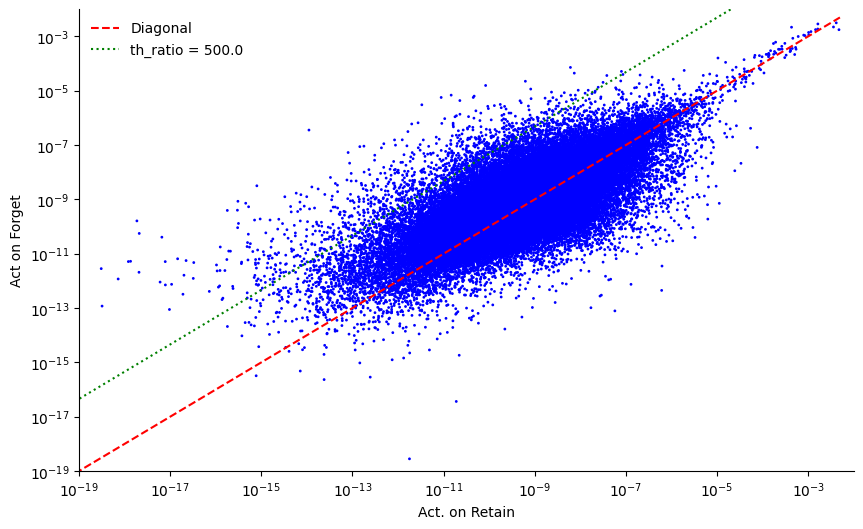

In [24]:
plot_importances(torch.norm(importances_fgt['W_dec'].data,dim=1),
                torch.norm(importances_retain['W_dec'].data,dim=1),
                torch.tensor([]))

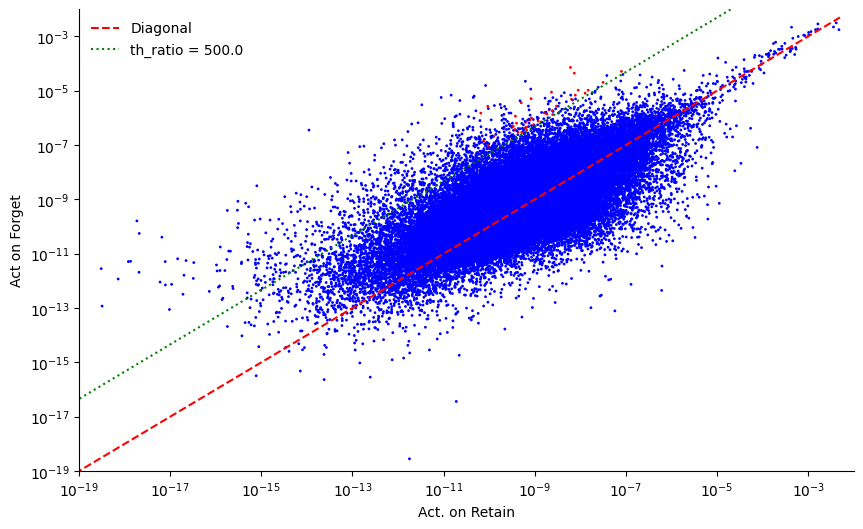

In [25]:
plot_importances(torch.norm(importances_fgt['W_dec'].data,dim=1),
                torch.norm(importances_retain['W_dec'].data,dim=1),
                indexes)

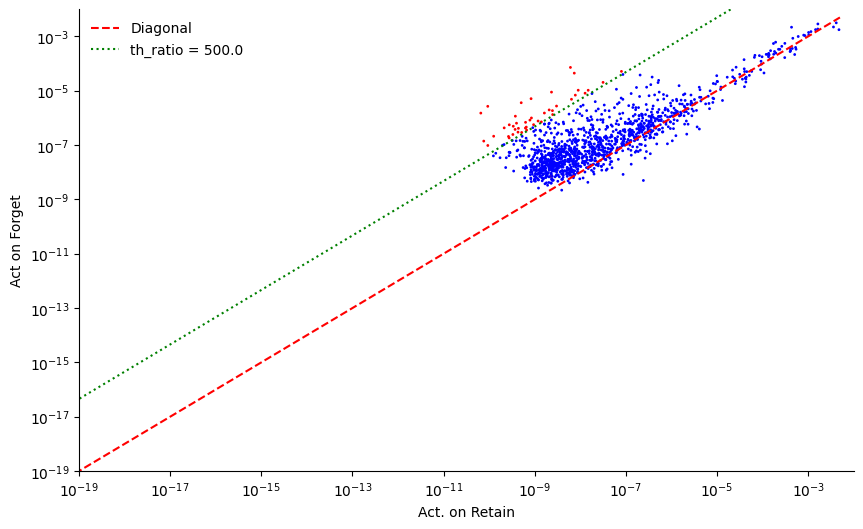

In [26]:
filt_index = torch.zeros_like(activations_sae_fgt)
filt_index[indexes] = 1
plot_importances(torch.norm(importances_fgt['W_dec'].data,dim=1)[activations_sae_fgt>0.05],
                torch.norm(importances_retain['W_dec'].data,dim=1)[activations_sae_fgt>0.05],
                torch.where(filt_index[activations_sae_fgt>0.05]==1)[0])

In [27]:
#load this file using pickle /home/jb/Documents/unlearning_sae/importances/google_gemma-2-2b-it_layer_3_width_65k_canonical_frequences.pkl
file_fgt = args.root_folder +'importances/google_gemma-2-2b-it_layer_3_width_65k_canonical_frequences.pkl'
with open(file_fgt, 'rb') as f:
    imp_dict = pkl.load(f)
    freq_fgt = imp_dict['forget']
    freq_rtn = imp_dict['retain']

In [28]:
#compute 95 percentile of the forget and retain frequencies
percentile_fgt = np.percentile(freq_fgt,5)
print(percentile_fgt)
percentile_rtn = np.percentile(freq_rtn,95)
print(percentile_rtn)

0.05239719226956368
0.02639978248625994


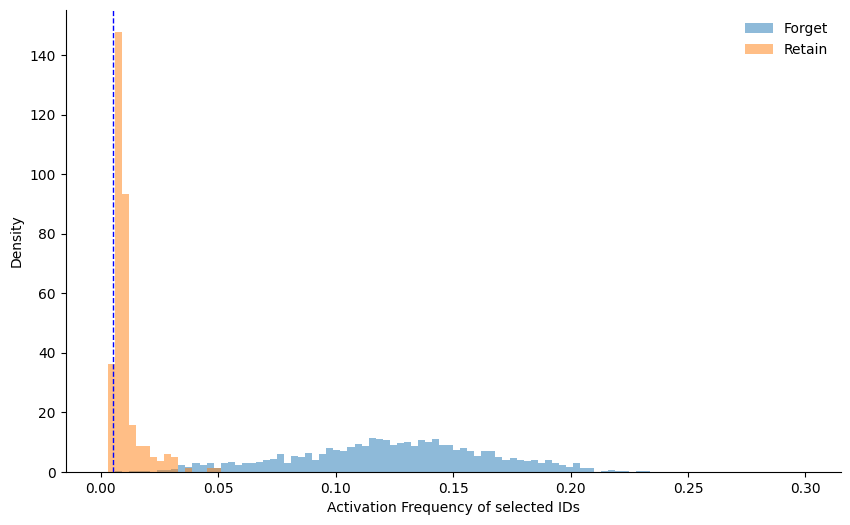

In [30]:
#plot histograms of the frequencies
fig,ax = plt.subplots(figsize=(10, 6),ncols=1,nrows=1)
ax.hist(freq_fgt,bins=100,range=(0,.3),alpha=0.5,label='Forget',density=True,stacked=True)
ax.hist(freq_rtn,bins=100,range=(0,.3),alpha=0.5,label='Retain',density=True,stacked=True)
ax.axvline(.005, color='blue', linestyle='dashed', linewidth=1)
ax.set_ylabel('Density')
ax.set_xlabel('Activation Frequency of selected IDs')
ax.legend(frameon=False)

In [ ]:
!pip show sae-lens